In [ ]:
!pip install pymysql

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.5 MB/s 


# 모듈 임포트

In [ ]:
import math
from math import sin, cos, sqrt, atan2, radians
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from bs4 import BeautifulSoup as bs
import scipy.cluster.hierarchy as shc
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score

plt.style.use('seaborn-white')
mpl.rc('font',family='Malgun Gothic') # 한글폰트 설정
mpl.rcParams['axes.unicode_minus'] = False # 마이너스 단위 설정

# 데이터 준비

In [ ]:
# db에 업데이트하는 사용자 함수
def update_db(df,df_name):
    import pymysql
    from sqlalchemy import create_engine

    db_connection_str = 'mysql+pymysql:[외부 db path]/source'
    db_connection = create_engine(db_connection_str)
    conn = db_connection.connect()

    df.to_sql(name = f'{df_name}',con = db_connection, index = False, if_exists = 'replace')

## 응급병원 위치 데이터
- 공공데이터포털 API - 중앙의료원_응급의료정보

In [ ]:
url = 'http://apis.data.go.kr/B552657/ErmctInfoInqireService/getEgytListInfoInqire'

params ={'serviceKey' : '', 
        'Q0' : '서울특별시', 
        # 'Q1' : '강남구', 
        # 'pageNo' : '1', 
        'numOfRows' : '1000' }

response = requests.get(url, params=params)
soup = bs(response.text,'html.parser')

In [ ]:
hpid = []
Name = []
Address = []
Longitude = []
Latitude = []

for i in soup.find_all('hpid'): hpid.append(i.get_text())
for i in soup.find_all('dutyname'): Name.append(i.get_text())
for i in soup.find_all('dutyaddr'): Address.append(i.get_text())
for i in soup.find_all('wgs84lon'): Longitude.append(i.get_text())
for i in soup.find_all('wgs84lat'): Latitude.append(i.get_text())

df = pd.DataFrame({'기관ID' : hpid, '기관명' : Name, '주소' : Address, '경도' : Longitude, '위도' : Latitude})

In [ ]:
# 총 49개의 병원
df.head()

,기관ID,기관명,주소,경도,위도
0,A1100008,(학)고려대학교의과대학부속병원(안암병원),"서울특별시 성북구 고려대로 73, 고려대병원 (안암동5가)",127.02647086385966,37.58715608002366
1,A1100011,가톨릭대학교여의도성모병원,"서울특별시 영등포구 63로 10, 여의도성모병원 (여의도동)",126.93673129599131,37.51827233800711
2,A1121013,가톨릭대학교은평성모병원,서울특별시 은평구 통일로 1021 (진관동),126.91615048739686,37.633608409726854
3,A1100043,강동경희대학교의대병원,서울특별시 강동구 동남로 892 (상일동),127.15752179822283,37.553476404020664
4,A1100006,강북삼성병원,서울특별시 종로구 새문안로 29 (평동),126.96793805451702,37.568497631233825


In [ ]:
update_db(df,'응급의료기관정보')

## 응급 의료기관 기본 정보 데이터
- 공공데이터포털 API - 국립중앙의료원_전국 병의원 정보


In [ ]:
# 파라미터명이 생소하여 구분이 힘드므로, 사용자함수를 통해 컬럼 이름이 구성되도록 함.
def make_df(soup):
    columns = {'hpid': '기관ID','dutyname':'기관명','dutyaddr':'주소','hvec':'잔여응급실','hvoc':'잔여수술실',
                'hvgc':'잔여입원실','wgs84lon':'경도','wgs84lat':'위도','hperyn':'응급실','hpopyn':'수술실',
                'hpgryn':'입원실','hpbdn':'병상수','hpicuyn':'일반중환자실'}
    df = pd.DataFrame(columns=list(columns.values()))
    for i in list(columns.keys()):
        globals()[f'{i}'] = []
        for j in soup.find_all('item'):
            try:
                globals()[f'{i}'].append(j.find(i).get_text())
            except:
                globals()[f'{i}'].append(np.nan)
        df[columns[i]] = globals()[f'{i}']
    return df

In [ ]:
# 1분 20초 소요
# 서울시만 뽑더라도 잘못된 분류와 결측치가 있어 전부 뽑은 뒤 join 하는 것으로 함
url = 'http://apis.data.go.kr/B552657/ErmctInfoInqireService/getEgytBassInfoInqire'
key = ''
pages = np.arange(1,11)
total_df = pd.DataFrame()
for page in pages:
        params ={'serviceKey' : key, 
                # 'STAGE1' : '서울특별시', 
                # 'STAGE2' : '강남구', 
                'pageNo' : page, 
                'numOfRows' : '1000' 
                }
        try:
                response = requests.get(url, params=params)
                soup = bs(response.text,'html.parser')
                globals()[f'df_{i}'] = make_df(soup)
        except:
                break
        total_df = pd.concat([total_df,globals()[f'df_{i}']])

In [ ]:
update_db(total_df,'응급의료기관정보_전체')

## 혈액원 위치정보
- 서울은 3개의 혈액원이 전체 지역의 혈액을 관리함.
- API도 있으나 불필요한 작업으로 생각되어 직접 DB에 입력하도록 함
- 경위도는 카카오지도를 참고하였음

In [ ]:
columns = ['기관명','주소']
df_bloodhome = pd.DataFrame(columns=columns)
df_bloodhome['기관명'] = ['서울중앙혈액원','서울남부혈액원','서울동부혈액원']
df_bloodhome['주소'] = ['서울특별시 강서구 공항대로 591 (염창동 280-17)','서울특별시 강남구 개포로31길 48 (개포동 1267)','서울특별시 노원구 동일로 1329 (상계6동 764)']
df_bloodhome['경도'] = [126.870808, 127.048767, 127.061883]
df_bloodhome['위도'] = [37.548049, 37.482129, 37.647144]
df_bloodhome


,기관명,주소,경도,위도
0,서울중앙혈액원,서울특별시 강서구 공항대로 591 (염창동 280-17),126.870808,37.548049
1,서울남부혈액원,서울특별시 강남구 개포로31길 48 (개포동 1267),127.048767,37.482129
2,서울동부혈액원,서울특별시 노원구 동일로 1329 (상계6동 764),127.061883,37.647144


In [ ]:
update_db(df_bloodhome,'혈액원위치정보')

# 드론공항 위치 결정

## 군집화 알고리즘 선택
### K means 알고리즘
- 장점
  - 간편하다.
- 단점
  - 데이터가 복잡하면 잘 작동하지 않는다.
  - 이상치에 민감하다.
  - 랜덤으로 중심을 잡기 때문에 실행 결과가 매번 다르다.

### Agglomerative Hierarchical Clustering 알고리즘
- 장점
  - 이상치에 강하다.
  - 비슷한 크기의 군집으로 묶어준다.

- 단점
  - 생소하다.

### 결론
PPT에서 언급하였듯, 현재 경우에는 결과의 차이가 없으나 훗날 UAM으로 확장됨에 따라 데이터가 복잡해질 것을 우려하여 Agglomerative Hierarchical Clustering 알고리즘을 선택함

## 병원 군집화
- 모든 응급 의료원을 위치정보를 가지고 군집화
- 혈액원도 함께 군집화 하고 혈액원이 있는 군집은 혈액원이 대표가 되도록 함
- 군집화 알고리즘으로는 Agglomerative Hierarchical Clustering을 사용

In [ ]:
import pymysql
import pandas as pd

conn = pymysql.connect(host='[ip]', user='root', password='', db='source')
sql_state = 'SELECT * FROM `혈액원위치정보`'
bloodhome = pd.read_sql_query(sql_state, conn)
sql_state = 'SELECT * FROM `응급의료기관정보_전체`'
hospital = pd.read_sql_query(sql_state, conn)
sql_state = 'SELECT * FROM `응급의료기관정보`'
emergency = pd.read_sql_query(sql_state, conn)

In [ ]:
# 기본정보에 결측이 있는 병원은 우선 삭제한다.
hospital = hospital.iloc[hospital[['경도','위도','응급실','수술실','입원실','병상수']].dropna().index].reset_index(drop=True)
hospital.drop(['주소','잔여응급실','잔여수술실','잔여입원실'],axis=1,inplace=True)
hospital = hospital[(hospital.응급실 != '0')&(hospital.수술실 != '0')]

# 위에서 말한 대로 응급병원들의 좌표정보와 기본 정보를 통합
hospital = emergency.drop(['기관명','주소','경도','위도'],axis=1).merge(hospital,on='기관ID',how='inner')

# 혈액원도 데이터프레임에 포함
bloodhome.drop('주소',axis=1,inplace=True)
hospital = pd.concat([hospital,bloodhome],axis=0,join='outer').drop('일반중환자실',axis=1).reset_index(drop=True)

In [ ]:
hospital.head()

,기관ID,기관명,경도,위도,응급실,수술실,입원실,병상수
0,A1100008,(학)고려대학교의과대학부속병원(안암병원),127.02647086385966,37.58715608002366,32,22,837,1048
1,A1100011,가톨릭대학교여의도성모병원,126.93673129599131,37.51827233800711,20,10,351,440
2,A1100043,강동경희대학교의대병원,127.15752179822283,37.553476404020664,22,14,687,667
3,A1100006,강북삼성병원,126.96793805451702,37.568497631233825,13,12,559,689
4,A1100002,건국대학교병원,127.0721229093036,37.54084479467721,27,18,729,869


In [ ]:
X = hospital[['경도','위도']]
X.head()

,경도,위도
0,127.02647086385966,37.58715608002366
1,126.93673129599131,37.51827233800711
2,127.15752179822283,37.553476404020664
3,126.96793805451702,37.568497631233825
4,127.0721229093036,37.54084479467721


In [ ]:
def visualize_silhouette_A(cluster_lists, X_features): 

    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    for ind, n_cluster in enumerate(cluster_lists):

        clusterer = AgglomerativeClustering(n_clusters=n_cluster, affinity='euclidean', linkage='ward')
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


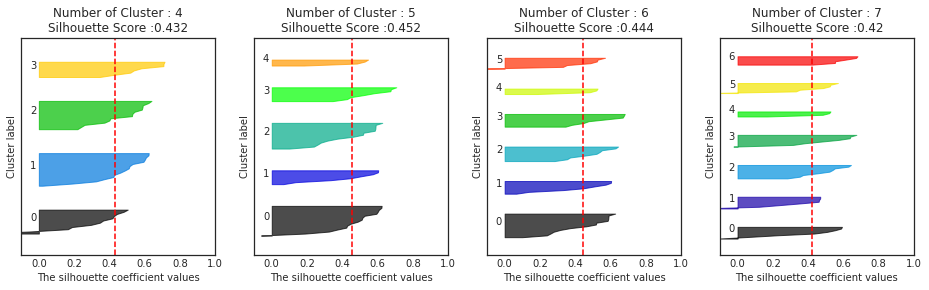

In [ ]:
visualize_silhouette_A([i for i in range(4,8)], X)

In [ ]:
def make_dendrogram(X):
    
    plt.figure(figsize=(20, 13))
    plt.title("Dendrograms")
    
    dend = shc.linkage(X, method='ward')
    cutoff = 0.15*max(dend[:,2])
    dendrogram = shc.dendrogram(dend, color_threshold = cutoff)

    plt.axhline(y = cutoff, color='r', linewidth=1);

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


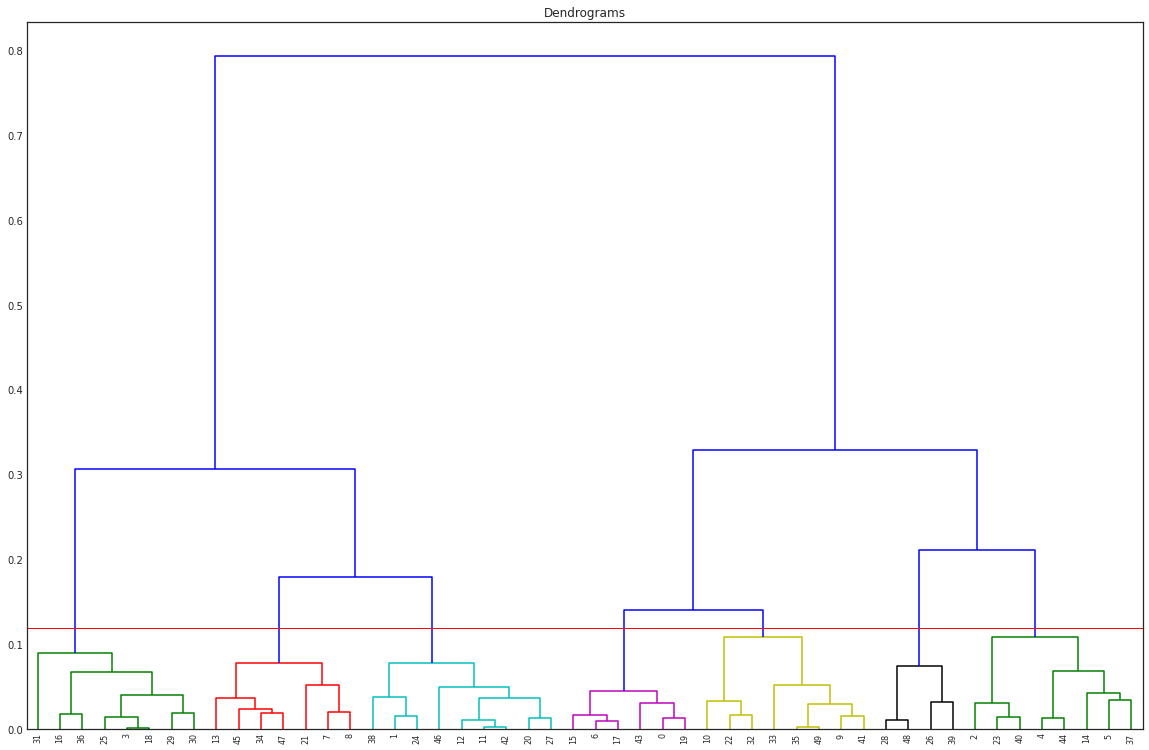

In [ ]:
#Dendrogram은 위 threshold에 대해 7개의 군집이 적합하다고 보임
make_dendrogram(X)

In [ ]:
# Dendrogram에서의 최적 군집수 7개였고, 실루엣 계수는 군집개수가 5와 6일 때가 높았다.
# 군집개수 5로 할 경우 군집 내 최대 거리가 10km가 넘는 군집이 생기므로, 현재 드론 스펙으로는 비행이 적합하지 않다.

# 따라서 군집 개수를 6개로 설정하고 응집형 계층적 군집화(AgglomerativeClustering) 시행
cluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
cluster.fit_predict(X)
labels = cluster.labels_
hospital['agglo_cluster'] = labels

## 군집별 대표 설정 - 드론 공항 위치
- 중심성이 높아야 함 (중심까지의 거리)
- 큰 병원이어야 함(혈액관리 및 공항 설치에 용이)
- 큰 병원은 또한 혈액 수요가 높을 가능성 (우선배부)

- 단, 설치비용을 절감하기 위하여 혈액원이 포함된 군집은 혈액원을 대표로 한다.

In [ ]:
# 문자열로 된 좌표정보를 실수화
hospital.경도 = hospital.경도.astype('float')
hospital.위도 = hospital.위도.astype('float')

In [ ]:
# 각 군집의 중심점 구하기
cluster_point = hospital[['경도','위도','agglo_cluster']].groupby('agglo_cluster').mean().reset_index()
cluster_point.columns = ['agglo_cluster','경도_c','위도_c']
cluster_point

,agglo_cluster,경도_c,위도_c
0,0,127.062118,37.606630
1,1,127.114205,37.525667
2,2,126.921349,37.494317
3,3,126.959677,37.577468
4,4,127.026056,37.502645
5,5,126.865125,37.524821


In [ ]:
# 두 점의 경위도 좌표로 거리를 계산하는 함수

R = 6371.0 # 지구반경

def distance_from_coord(o_coord, d_coord):
    x1, y1 = radians(o_coord[0]), radians(o_coord[1])
    x2, y2 = radians(d_coord[0]), radians(d_coord[1])
    dlon = x2 - x1
    dlat = y2 - y1
    a = sin(dlat / 2)**2 + cos(y1) * cos(y2) * sin(dlon / 2)**2 
    c = 2 * atan2(sqrt(a), sqrt(1 - a))    
    return R * c

In [ ]:
# 각 군집의 중심좌표로부터 떨어진 거리의 역수로 '중심거리지수'를 정의
# 중심에 가까울수록 이 숫자가 크다

df = hospital.merge(cluster_point,on='agglo_cluster',how='inner')
distance = []
for i in range(len(df.agglo_cluster)):
  distance.append(1 / distance_from_coord([df.경도[i],df.위도[i]],[df.경도_c[i],df.위도_c[i]]))
df['중심거리지수'] = distance
df.drop(['경도_c','위도_c'],axis=1,inplace=True)
df.head()

,기관ID,기관명,경도,위도,응급실,수술실,입원실,병상수,agglo_cluster,중심거리지수
0,A1100008,(학)고려대학교의과대학부속병원(안암병원),127.026471,37.587156,32,22,837,1048,0,0.262140
1,A1100001,경희대학교병원,127.051832,37.593877,21,16,604,850,0,0.594199
2,A1100048,노원을지대학교병원,127.070003,37.636443,23,10,449,512,0,0.295250
3,A1100044,녹색병원,127.086055,37.583621,10,3,299,318,0,0.301593
4,A1100021,삼육서울병원,127.065329,37.587992,21,5,406,431,0,0.478078


In [ ]:
update_db(df,'군집화된병원6')

In [ ]:
# 혈액원이 포함된 군집은 설치비용을 줄일 수 있도록 혈액원이 대표로 함
# 따라서, 이외의 것들만 분석
df[df.기관ID.isnull()].agglo_cluster.values
df2 = df[(df.agglo_cluster != 0)&(df.agglo_cluster != 4)&(df.agglo_cluster != 5)]
df2.fillna(0)
df2.head()

,기관ID,기관명,경도,위도,응급실,수술실,입원실,병상수,agglo_cluster,중심거리지수
14,A1100011,가톨릭대학교여의도성모병원,126.936731,37.518272,20,10,351,440,2,0.334513
15,A1100037,대림성모병원,126.907169,37.490689,10,4,178,208,2,0.760802
16,A1100024,명지성모병원,126.899254,37.493851,10,3,234,243,2,0.512837
17,A1100040,서울특별시보라매병원,126.924049,37.493718,43,14,705,763,2,4.043414
18,A1100054,성애의료재단성애병원,126.922367,37.512050,21,5,255,276,2,0.506599


In [ ]:
# 대표성의 변수들의 각 영향이 동일하도록 스케일링.
# 각 변수들에 대해 가중치를 임의로 줄 수도 있지만 현재는 같은 영향으로 가정한다.
scaler = MinMaxScaler()
df3 = df2.copy()
for i in ['응급실','수술실','입원실','병상수','중심거리지수']:
  df3[i] = scaler.fit_transform(df2[[i]])
df3.head()

,기관ID,기관명,경도,위도,응급실,수술실,입원실,병상수,agglo_cluster,중심거리지수
14,A1100011,가톨릭대학교여의도성모병원,126.936731,37.518272,0.101010,0.100000,0.077094,0.095086,2,0.043124
15,A1100037,대림성모병원,126.907169,37.490689,0.000000,0.014286,0.000000,0.002397,2,0.153104
16,A1100024,명지성모병원,126.899254,37.493851,0.000000,0.000000,0.024955,0.016380,2,0.089131
17,A1100040,서울특별시보라매병원,126.924049,37.493718,0.333333,0.157143,0.234848,0.224131,2,1.000000
18,A1100054,성애의료재단성애병원,126.922367,37.512050,0.111111,0.028571,0.034314,0.029565,2,0.087521


In [ ]:
# 대표성을 나타내는 지수를 모든 변수의 합 '대표성지수'로 정의
# 군집별 최대 대표성지수를 확인
df3['대표성지수'] = df3['응급실'] + df3['수술실'] + df3['입원실'] + df3['병상수'] + df3['중심거리지수']
df4 = df3[['agglo_cluster','대표성지수']].groupby('agglo_cluster').max()
df4

,대표성지수
agglo_cluster,
1,4.438583
2,1.949456
3,2.642909


In [ ]:
# 해당 대표성 지수를 가진 기관의 기관명과 위치좌표를 가져온다
temp1 = df3.merge(df4.reset_index(),how='inner').drop(['기관ID','응급실','수술실','입원실','병상수','중심거리지수','대표성지수'],axis=1)
temp2 = df[df.기관ID.isnull()].drop(['기관ID','응급실','수술실','입원실','병상수','중심거리지수'],axis=1)
df_representative = pd.concat([temp1,temp2],axis=0).reset_index(drop=True).sort_values('agglo_cluster').reset_index(drop=True)

In [ ]:
# 이제, 혈액원과 새로 구성한 임시 혈액원을 확인
# 이곳들이 드론 공항이 설치될 위치
df_representative

,기관명,경도,위도,agglo_cluster
0,서울동부혈액원,127.061883,37.647144,0
1,재단법인아산사회복지재단서울아산병원,127.108238,37.526564,1
2,서울특별시보라매병원,126.924049,37.493718,2
3,학교법인연세대학교의과대학세브란스병원,126.940828,37.562117,3
4,서울남부혈액원,127.048767,37.482129,4
5,서울중앙혈액원,126.870808,37.548049,5


In [ ]:
update_db(df_representative,'드론공항위치')